In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Test Cases for LSTM Training

This worksheet contains code that generates a variety of LSTM test cases. The output files are suitable for use with `clstmseq`.

In [2]:
from pylab import *
from scipy.ndimage import filters

default_ninput = 2
default_n = 29

Here is a simple utility class to write out sequence data to an HDF5 file quickly.

In [3]:
import h5py
import numpy as np

class H5SeqData:
    def __init__(self,fname,N=None):
        self.fname = fname
        h5 = h5py.File("rnntest-"+fname+".h5","w")
        self.h5 = h5
        dt = h5py.special_dtype(vlen=np.dtype('float32'))
        it = np.dtype('int32')
        self.inputs = h5.create_dataset("inputs",(1,), maxshape=(None,),compression="gzip",dtype=dt)
        self.inputs_dims = h5.create_dataset("inputs_dims",(1,2), maxshape=(None,2), dtype=it)
        self.outputs = h5.create_dataset("outputs",(1,),maxshape=(None,),compression="gzip",dtype=dt)
        self.outputs_dims = h5.create_dataset("outputs_dims",(1,2), maxshape=(None,2), dtype=it)
        self.fill = 0
        if N is not None: self.resize(N)
    def close(self):
        self.h5.close()
        self.h5 = None
    def __enter__(self):
        print "writing",self.fname
        return self
    def __exit__(self, type, value, traceback):
        self.close()
        print "done writing",self.fname
    def resize(self,n):
        self.inputs.resize((n,))
        self.inputs_dims.resize((n,2))
        self.outputs.resize((n,))
        self.outputs_dims.resize((n,2))
    def add(self,inputs,outputs):
        self.inputs[self.fill] = inputs.ravel()
        self.inputs_dims[self.fill] = array(inputs.shape,'i')
        self.outputs[self.fill] = outputs.ravel()
        self.outputs_dims[self.fill] = array(outputs.shape,'i')
        self.fill += 1

N = 50000

In [4]:
def genfile(fname,f):
    with H5SeqData(fname,N) as db:
        for i in range(N):
            xs,ys = f()
            db.add(xs,ys)

In [5]:
def plotseq(fname,index=17):
    h5 = h5py.File(fname,"r")
    try:
        inputs = h5["inputs"][index].reshape(*h5["inputs_dims"][index])
        outputs = h5["outputs"][index].reshape(*h5["outputs_dims"][index])
        plot(inputs[:,0],'r-',linewidth=5,alpha=0.5)
        if inputs.shape[1]>1:
            plot(inputs[:,1:],'r-',linewidth=1,alpha=0.3)
        plot(outputs,'b--')
    finally:
        h5.close()

In [6]:
def generate_threshold(n=default_n,ninput=default_ninput,threshold=0.5,example=0):
    "No temporal dependencies, just threshold of the sum of the inputs."
    x = rand(n,ninput)
    y = 1.0*(sum(x,axis=1)>threshold*ninput).reshape(n,1)
    return x,y

genfile("threshold", generate_threshold)

writing threshold
done writing threshold


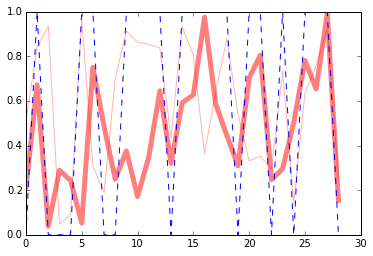

In [7]:
plotseq("rnntest-threshold.h5")

In [8]:
def generate_mod(n=default_n,ninput=default_ninput,m=3,example=0):
    "Generate a regular beat every m steps. The input is random."
    x = rand(n,ninput)
    y = 1.0*(arange(n,dtype='i')%m==0).reshape(n,1)
    return x,y

genfile("mod3", generate_mod)

writing mod3
done writing mod3


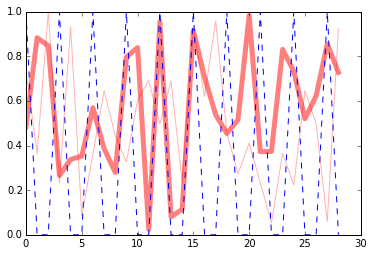

In [9]:
plotseq("rnntest-mod3.h5")

In [10]:
def generate_dmod(n=default_n,ninput=default_ninput,m=3,example=0):
    """Generate a regular beat every m steps, the input is random
    except for the first dimension, which contains a downbeat
    at the very beginning."""
    x = rand(n,ninput)
    y = 1.0*(arange(n,dtype='i')%m==0).reshape(n,1)
    x[:,0] = 0
    x[0,0] = 1
    return x,y

genfile("dmod3", generate_dmod)
genfile("dmod4", lambda:generate_dmod(m=4))
genfile("dmod5", lambda:generate_dmod(m=5))
genfile("dmod6", lambda:generate_dmod(m=6))

writing dmod3
done writing dmod3
writing dmod4
done writing dmod4
writing dmod5
done writing dmod5
writing dmod6
done writing dmod6


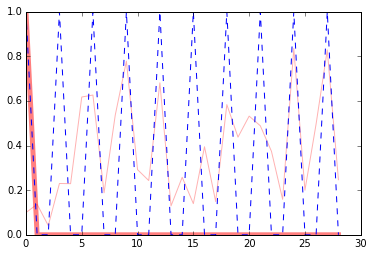

In [11]:
plotseq("rnntest-dmod3.h5")

In [12]:
def generate_imod(n=default_n,ninput=default_ninput,m=3,p=0.2,example=0):
    """Generate an output for every m input pulses."""
    if example:
        x = array(arange(n)%4==1,'i')
    else:
        x = array(rand(n)<p,'i')
    y = (add.accumulate(x)%m==1)*x*1.0
    x = array(vstack([x]*ninput).T,'f')
    y = y.reshape(len(y),1)
    return x,y

genfile("imod3", generate_imod)
genfile("imod4", lambda:generate_imod(m=4))

writing imod3
done writing imod3
writing imod4
done writing imod4


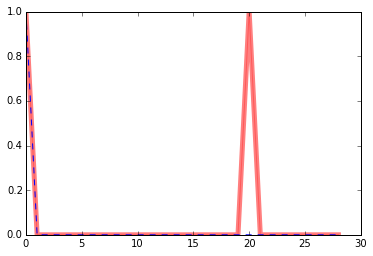

In [13]:
plotseq("rnntest-imod3.h5")

In [14]:
def generate_smod(n=default_n,ninput=default_ninput,m=3,r=0.5,example=0):
    """Generate an output for every m input pulses. The input
    is band limited, so it's a little easier than generate_imod."""
    x = rand(n)
    x = filters.gaussian_filter(x,r)
    x = (x>roll(x,-1))*(x>roll(x,1))
    y = (add.accumulate(x)%m==1)*x*1.0
    x = array(vstack([x]*ninput).T,'f')
    y = y.reshape(len(y),1)
    return x,y

genfile("smod3", generate_smod)
genfile("smod4", lambda:generate_smod(m=4))
genfile("smod5", lambda:generate_smod(m=5))

writing smod3
done writing smod3
writing smod4
done writing smod4
writing smod5
done writing smod5


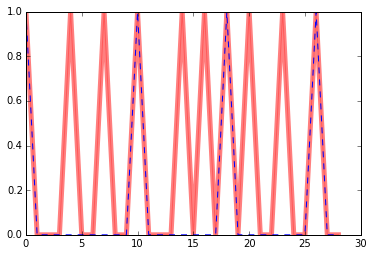

In [15]:
plotseq("rnntest-smod3.h5")

In [16]:
def generate_anbn(ninput=default_ninput,n=default_n,k=default_n//3,example=0):
    """A simple detector for a^nb^n. Note that this does not
    train the network to distinguish this langugage from other languages."""
    inputs = zeros(n)
    outputs = zeros(n)
    if example:
        l = n//3
    else:
        l = 1+int((k-1)*rand())
    inputs[:l] = 1
    outputs[2*l] = 1
    outputs = outputs.reshape(len(outputs),1)
    return vstack([inputs]*ninput).T,outputs

genfile("anbn", generate_anbn)

writing anbn
done writing anbn


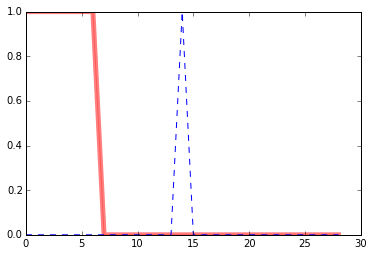

In [17]:
plotseq("rnntest-anbn.h5")

In [18]:
def generate_timing(ninput=default_ninput,n=default_n,t=5,example=0):
    """A simple timing related task: output a spike if no spike occurred within
    t time steps before."""
    x = 0
    inputs = []
    while x<n:
        inputs.append(x)
        x += max(1,0.5*t*randn()+t)
    inputs = [-999990]+inputs
    outputs = []
    for i in range(1,len(inputs)):
        if inputs[i]-inputs[i-1]>t:
            outputs.append(inputs[i])
    inputs = inputs[1:]
    xs = zeros((n,ninput))
    xs[inputs,:] = 1.0
    ys = zeros((n,1))
    ys[outputs,:] = 1.0
    return xs,ys

genfile("timing", generate_timing)

writing timing
done writing timing


In [19]:
def generate_revtiming(ninput=default_ninput,n=default_n,t=5,example=0):
    """A simple timing related task: output a spike if no spike occurs within
    t time steps after. This cannot be learned using a causal model (it requires
    a reverse model)."""
    x = 0
    inputs = []
    while x<n:
        inputs.append(x)
        x += max(1,0.5*t*randn()+t)
    inputs = inputs+[999999]
    outputs = []
    for i in range(len(inputs)-1):
        if inputs[i+1]-inputs[i]>t:
            outputs.append(inputs[i])
    inputs = inputs[:-1]
    xs = zeros((n,ninput))
    xs[inputs,:] = 1.0
    ys = zeros((n,1))
    ys[outputs,:] = 1.0
    return xs,ys

genfile("revtiming", generate_revtiming)

writing revtiming
done writing revtiming


In [20]:
def generate_biditiming(ninput=default_ninput,n=default_n,t=5,example=0):
    x = 0
    inputs = []
    while x<n:
        inputs.append(x)
        x += max(1,0.5*t*randn()+t)
    inputs = [-999999]+inputs+[999999]
    outputs = []
    for i in range(1,len(inputs)-1):
        if inputs[i+1]-inputs[i]>=t and inputs[i]-inputs[i-1]>=t:
            outputs.append(inputs[i])
    inputs = inputs[1:-1]
    xs = zeros((n,ninput))
    xs[inputs,:] = 1.0
    ys = zeros((n,1))
    ys[outputs,:] = 1.0
    return xs,ys

genfile("biditiming", generate_biditiming)

writing biditiming
done writing biditiming


In [21]:
def detect_12(x):
    n = len(x)
    y = zeros(n)
    state = 0
    for i in range(n):
        s = tuple(1*(x[i]>0.5))
        if s==(0,0): pass
        elif s==(1,0): state = 1
        elif s==(0,1) and state==1:
            y[i] = 1
            state = 0
        else: state = 0
    return y

In [22]:
def generate_detect(n=default_n,ninput=default_ninput,m=3,r=0.5,example=0):
    """Generates a random sequence of bits and outputs a "1" whenever there is
    a sequence of inputs 01-00*-10"""
    x = rand(n,2)
    x = filters.gaussian_filter(x,(r,0))
    x = 1.0*(x>roll(x,-1,0))*(x>roll(x,1,0))
    y = detect_12(x)
    return x,y.reshape(len(y),1)

genfile("detect", generate_detect)

writing detect
done writing detect


In [23]:
def generate_revdetect(n=default_n,ninput=default_ninput,m=3,r=0.5,example=0):
    """Reverse of generate_detect."""
    xs,ys = generate_detect(n=n,ninput=ninput,m=m,r=r,example=example)
    return array(xs)[::-1],array(ys)[::-1]

genfile("revdetect", generate_revdetect)

writing revdetect
done writing revdetect


In [24]:
def generate_bididetect(n=default_n,ninput=default_ninput,m=3,r=0.5,example=0):
    """Generate a particular pattern whenever there is some input trigger."""
    xs,ys = generate_detect(n=n,ninput=ninput,m=m,r=r,example=example)
    rys = detect_12(xs[::-1])[::-1].reshape(len(ys),1)
    return array(xs),array(ys*rys)

genfile("bididetect", generate_bididetect)

writing bididetect
done writing bididetect


In [25]:
def generate_predict_and_sync():
    """Similar to smod, but the correct output is provided one step after
    the required prediction for resynchronization."""
    pass

In [26]:
def generate_distracted_recall():
    """Distracted sequence recall example."""
    pass

In [27]:
def generate_morse():
    """Morse code encoding/decoding."""
    pass


In [28]:
def genseq_timing1(n=30,threshold=0.2,m=4,example=0):
    """Returns an output for every input within m time steps.
    A 1 -> N -> 1 problem."""
    x = (rand(n)<threshold)
    l = find(x)
    y = zeros(len(x))
    for i in range(1,len(l)):
        if l[i]-l[i-1]<m: y[l[i]] = 1
    return (1.0*x).reshape(n,1),y.reshape(n,1)

In [29]:
def genseq_threshold1(n=30,d=3,threshold=0.5,c=0,scale=1.0):
    """Threshold on the first component only."""
    x = randn(n,d)
    y = (1.0*(x[:,c]>threshold)).reshape(len(x),1)
    x[:,c] *= scale
    return x,y

In [30]:
def genseq_delay(n=30,threshold=0.2,d=1):
    """Returns an output for every input within m time steps.
    A 1 -> N -> 1 problem."""
    x = array(rand(n)<threshold,'f')
    y = roll(x,d)
    if d>0: y[:d] = 0
    elif d<0: y[d:] = 0
    return x.reshape(n,1),y.reshape(n,1)

genfile("delay1", genseq_delay)
genfile("delay2", lambda:genseq_delay(d=2))
genfile("delay3", lambda:genseq_delay(d=3))
genfile("rdelay1", lambda:genseq_delay(d=-1))
genfile("rdelay2", lambda:genseq_delay(d=-2))
genfile("rdelay3", lambda:genseq_delay(d=-3))

writing delay1
done writing delay1
writing delay2
done writing delay2
writing delay3
done writing delay3
writing rdelay1
done writing rdelay1
writing rdelay2
done writing rdelay2
writing rdelay3
done writing rdelay3


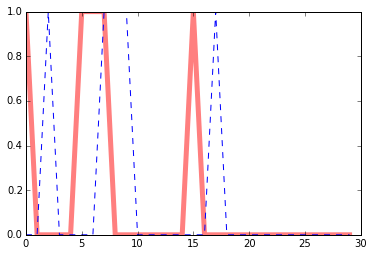

In [31]:
plotseq("rnntest-delay2.h5")

# Test Run with `clstmseq`

Here is a simple example of sequence training with `clstmseq`. It takes one of the HDF5 files we generated above as an example. By default, it uses every tenth training sample as part of a test set. The `TESTERR` it reports is MSE error and binary error rate (assuming a threshold of 0.5).

In [34]:
!lrate=1e-3 report_every=5000 ntrain=20000 test_every=10000 ../clstmseq rnntest-delay1.h5

got 50000 training samples
ninput 1 noutput 2

0
INP __!_!_________!_!_______!_____
OUT @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
TRU ___@_@_________@_@_______@____


5000
INP __!______!_!__!________!_!__!!
OUT ___@______@_@__@________@_@__@
TRU ___@______@_@__@________@_@__@

TESTERR 7.96989e-08 2.0849e-07 CERR 0 0 N 5000 at 10000

15000
INP ______________!___!!!__!____!_
OUT _______________@___@@@__@____@
TRU _______________@___@@@__@____@

TESTERR 1.69989e-08 4.44687e-08 CERR 0 0 N 5000 at 20000
